In [1]:
import psycopg2
import datetime
import numpy as np
import pandas as pd
from itertools import islice
from sklearn import preprocessing

import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters

import torch
from torch import nn, optim

from finance.utilities import utils
from finance.data_science.utilities import (financial_utils, time_series_utils, 
                                            cluster_utils, random_forest_utils, nn_utils)

### Get stock data

In [2]:
query_date = '2010-01-01'
query = f"""
    with 
    tickers as (
    select distinct 
        ticker
        , sector
        , industry
    from nasdaq.listed_stocks
    where ticker in ('T') --, 'BA', 'MMM', 'GA', 'GM', 'GE', 'AAPL', 'MSFT', 'DOW', 'AXP', 'IBM', 'JPM')
    limit 100
    ),
    stocks as (
        select 
            market_datetime
            , symbol
            , sector
            , industry
            , (open + close) / 2 as average_price_today
            , volume
            , avg(open) over (partition by symbol order by market_datetime rows between 100 preceding and current row) as average_open_hundred_days
            , avg(open) over (partition by symbol order by market_datetime rows between 50 preceding and current row) as average_open_fifty_days
            , avg(open) over (partition by symbol order by market_datetime rows between 10 preceding and current row) as average_open_ten_days
            , max(open) over (partition by symbol order by market_datetime rows between 100 preceding and current row) as high_open_hundred_days
            , min(open) over (partition by symbol order by market_datetime rows between 100 preceding and current row) as low_open_hundred_days
            , avg(volume) over (partition by symbol order by market_datetime rows between 100 preceding and current row) as average_volume_hundred_days
            , avg(volume) over (partition by symbol order by market_datetime rows between 50 preceding and current row) as average_volume_fifty_days
            , avg(volume) over (partition by symbol order by market_datetime rows between 10 preceding and current row) as average_volume_ten_days
            , avg((open - close)/open) over (partition by symbol order by market_datetime rows between 10 preceding and current row) as average_daily_finish_ten_days
            , avg((high - low)/high) over (partition by symbol order by market_datetime rows between 10 preceding and current row) as average_daily_range_ten_days
            , avg(open) over (partition by symbol order by market_datetime rows between 9 following and 49 following) as forward_average
            , max(open) over (partition by symbol order by market_datetime rows between 9 following and 49 following) as forward_high
            , min(open) over (partition by symbol order by market_datetime rows between 9 following and 49 following) as forward_low
        from td.equities as equities
        inner join tickers
            on tickers.ticker = equities.symbol
        where market_datetime > '{query_date}'
        ),
    summary as (
        select *
            , (average_open_hundred_days - average_open_fifty_days) / average_open_hundred_days 
                as hundred_fifty_average_open_diff
            , (average_open_fifty_days - average_open_ten_days) / average_open_fifty_days 
                as fifty_ten_average_open_diff
            , (high_open_hundred_days - low_open_hundred_days) / high_open_hundred_days 
                as hundred_high_low_open_diff
            , (average_volume_hundred_days - average_volume_fifty_days) / average_volume_hundred_days 
                as hundred_fifty_average_volume_diff
            , (average_volume_fifty_days - average_volume_ten_days) / average_volume_fifty_days 
                as fifty_ten_average_volume_diff
            --, (forward_average - average_price_today) / average_price_today as target
            --, (forward_high - forward_low) / forward_average as target
            , forward_average as target
        from stocks
        where forward_average is not null
        and market_datetime > '{query_date}'::date + interval '100' day)
    select *
        , avg(hundred_fifty_average_open_diff) over (partition by market_datetime, sector) as sector_hundred_fifty_average_open_diff
        , avg(fifty_ten_average_open_diff) over (partition by market_datetime, sector) as sector_fifty_ten_average_open_diff
        , avg(hundred_high_low_open_diff) over (partition by market_datetime, sector) as sector_hundred_high_low_open_diff
        , avg(fifty_ten_average_volume_diff) over (partition by market_datetime, sector) as sector_fifty_ten_average_volume_diff
        , avg(hundred_fifty_average_open_diff) over (partition by market_datetime, industry) as industry_hundred_fifty_average_open_diff
        , avg(fifty_ten_average_open_diff) over (partition by market_datetime, industry) as industry_fifty_ten_average_open_diff
        , avg(hundred_high_low_open_diff) over (partition by market_datetime, industry) as industry_hundred_high_low_open_diff
        , avg(fifty_ten_average_volume_diff) over (partition by market_datetime, industry) as industry_fifty_ten_average_volume_diff
        , avg(hundred_fifty_average_open_diff) over (partition by market_datetime) as market_hundred_fifty_average_open_diff
        , avg(fifty_ten_average_open_diff) over (partition by market_datetime) as market_fifty_ten_average_open_diff
        , avg(hundred_high_low_open_diff) over (partition by market_datetime) as market_hundred_high_low_open_diff
        , avg(fifty_ten_average_volume_diff) over (partition by market_datetime) as market_fifty_ten_average_volume_diff
    from summary
    order by market_datetime
    """

df = utils.query_db(query=query)
df.head()

,market_datetime,symbol,sector,industry,average_price_today,volume,average_open_hundred_days,average_open_fifty_days,average_open_ten_days,high_open_hundred_days,...,sector_hundred_high_low_open_diff,sector_fifty_ten_average_volume_diff,industry_hundred_fifty_average_open_diff,industry_fifty_ten_average_open_diff,industry_hundred_high_low_open_diff,industry_fifty_ten_average_volume_diff,market_hundred_fifty_average_open_diff,market_fifty_ten_average_open_diff,market_hundred_high_low_open_diff,market_fifty_ten_average_volume_diff
0,2010-04-12 05:00:00,T,Public Utilities,Telecommunications Equipment,26.475,22940169.0,25.859265,25.585294,26.141818,28.7,...,0.137282,-0.030665,0.010595,-0.021752,0.137282,-0.030665,0.010595,-0.021752,0.137282,-0.030665
1,2010-04-13 05:00:00,T,Public Utilities,Telecommunications Equipment,26.260,38016740.0,25.865942,25.597451,26.155455,28.7,...,0.137282,-0.104830,0.010380,-0.021799,0.137282,-0.104830,0.010380,-0.021799,0.137282,-0.104830
2,2010-04-14 05:00:00,T,Public Utilities,Telecommunications Equipment,26.205,27719603.0,25.870286,25.608431,26.139091,28.7,...,0.137282,-0.137442,0.010122,-0.020722,0.137282,-0.137442,0.010122,-0.020722,0.137282,-0.137442
3,2010-04-15 05:00:00,T,Public Utilities,Telecommunications Equipment,26.200,28001022.0,25.874366,25.618039,26.132727,28.7,...,0.137282,-0.065420,0.009907,-0.020091,0.137282,-0.065420,0.009907,-0.020091,0.137282,-0.065420
4,2010-04-16 05:00:00,T,Public Utilities,Telecommunications Equipment,26.065,31988637.0,25.878889,25.634314,26.160000,28.7,...,0.137282,-0.049402,0.009451,-0.020507,0.137282,-0.049402,0.009451,-0.020507,0.137282,-0.049402


### Clean data

In [3]:
df['market_datetime_month'] = df['market_datetime'].dt.month
df['market_datetime_day_of_week'] = df['market_datetime'].dt.dayofweek

df['market_datetime_int'] = df['market_datetime'].astype(int)

df = cluster_utils.encode_one_hot(df, ['symbol', 'sector', 'industry', 
                                       'market_datetime_month', 'market_datetime_day_of_week'])

In [4]:
cols_to_ignore = ['symbol', 'sector', 'industry', 'market_datetime', 'market_datetime_month', 'market_datetime_day_of_week', 
                  'forward_average', 'forward_high', 'forward_low', 'target']

for col in df.drop(cols_to_ignore, axis=1).columns:
    df = cluster_utils.normalize(df=df, column=col)

cluster_utils.normalize(df=df, column='target')
df = df.fillna(1)

In [5]:
df.head(1).T

,0
market_datetime,2010-04-12 05:00:00
symbol,T
sector,Public Utilities
industry,Telecommunications Equipment
average_price_today,0.119585
volume,0.0854201
average_open_hundred_days,0.026769
average_open_fifty_days,0.0365571
average_open_ten_days,0.0904152
high_open_hundred_days,0.116945


In [6]:
temp = df.copy()

y = temp['target']

x = temp[~y.isna()].reset_index(drop=True)
y = y[~y.isna()].reset_index(drop=True)

split = .8
cutoff = int(len(x) * .8)

train_x = x.iloc[:cutoff]
test_x = x.iloc[cutoff:]

train_y = y.iloc[:cutoff]
test_y = y.iloc[cutoff:]

### Create nn

In [7]:
model = nn_utils.TorchLSTM(train_x=train_x.drop(cols_to_ignore, axis=1), 
                           train_y=train_y,
                           test_x=test_x.drop(cols_to_ignore, axis=1), 
                           test_y=test_y,
                           n_layers=2,
                           n_epochs=30,
                           hidden_shape=1000,
                           learning_rate=.001,
                           device='cuda:1')

In [8]:
model.execute()

Epoch  0 MSE:  2070747.125
Epoch  3 MSE:  805210.4375
Epoch  6 MSE:  1276172.25
Epoch  9 MSE:  1916788.875
Epoch  12 MSE:  1049411.0
Epoch  15 MSE:  1100194.25
Epoch  18 MSE:  736554.5625
Epoch  21 MSE:  830445.0625
Epoch  24 MSE:  688326.875
Epoch  27 MSE:  700737.875


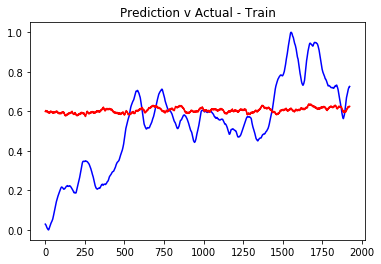

In [9]:
model.plot_prediction_train()

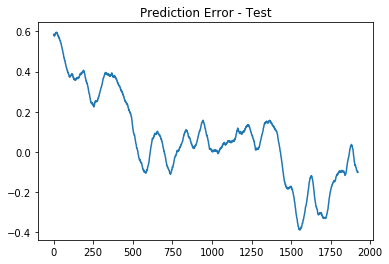

In [10]:
model.plot_prediction_train_error()

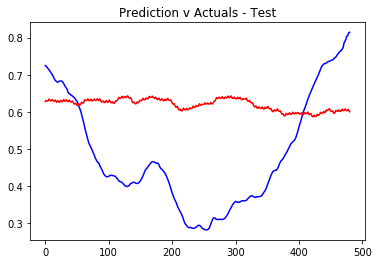

In [11]:
model.plot_prediction_test()

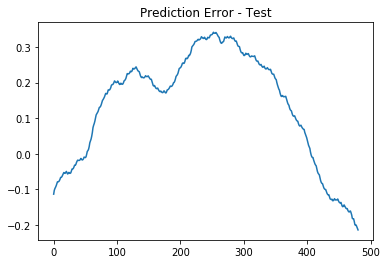

In [12]:
model.plot_prediction_test_error()

In [16]:
model.reset_network()